# Conditional Random Field implementation
## Using small number of demonstrations, no adversarial data
### Now using a discritivation of the state space so that I can represent interesting state features

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import gym
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics


Bad key "text.kerning_factor" on line 4 in
/home/brendanjcrowe/anaconda3/envs/seq/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


### Load Expert Data 

In [39]:
from experts import Expert

ENV_NAME = 'MountainCar-v0'
expert = Expert(ENV_NAME)

data, avg_reward, splits = expert.generate_data(num_episodes=25)
sequences = np.split(data, splits)[0:-1]
avg_reward

-106.68

### Visualize data

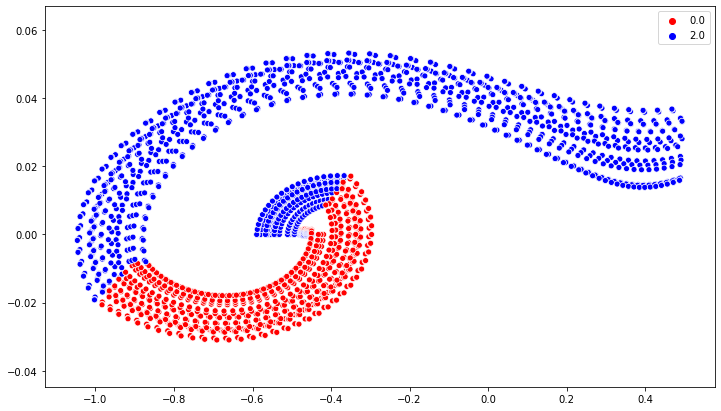

In [40]:
fig, ax = plt.subplots(figsize=(12, 7))
colors = np.array(['red', 'green', 'blue'])
palette = colors[np.unique(data[:,2]).astype(np.int32)].tolist()
sns.scatterplot(data[:,0], data[:,1], hue=data[:,2], palette=palette)

### Define feature function, and functions to transform data into correct for for crf

In [41]:
def feats(seq, k):
    
    return {
            'position': np.format_float_positional(seq[k-1][0], 2, unique=False),
            'velocity': np.format_float_positional(seq[k-1][1], 3, unique=False),
            'position1': np.format_float_positional(seq[k][0], 2, unique=False),
            'velocity1': np.format_float_positional(seq[k][1], 3, unique=False),
            'first': k == 0,
            'last': k == len(seq)-1,
            'bias': True
    }

def labs(seq, k):
    
    return str(seq[k][2])
    
def seq_to_feats(seq):
    
    return [feats(seq, k) for k in range(len(seq))]

def seq_to_labs(seq):
    
    return [labs(seq, k) for k in range(len(seq))]

X_train = [seq_to_feats(seq) for seq in sequences]
y_train = [seq_to_labs(seq) for seq in sequences]


### Train CRF

In [48]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=10000,
    all_possible_transitions=True,
    all_possible_states=True
)
crf.fit(X_train, y_train)

/home/brendanjcrowe/anaconda3/envs/seq/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=True, all_possible_transitions=True,
    keep_tempfiles=None, max_iterations=10000)

In [49]:
y_hat = np.array(np.hstack([np.array(seq_hat, dtype=np.float64) for seq_hat in crf.predict(X_train)]))

### Visualize learned policy

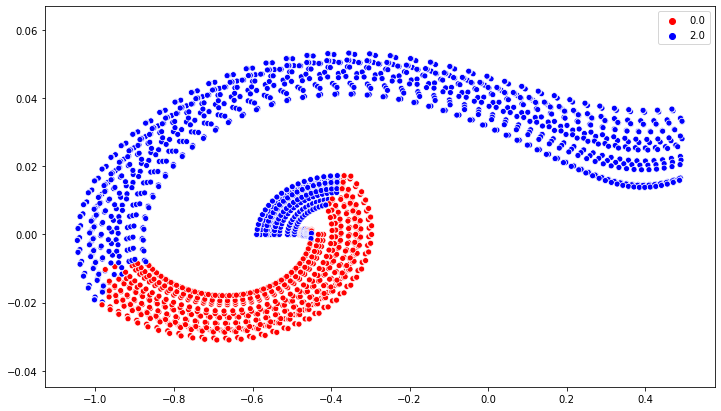

In [50]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(data[:,0], data[:,1], hue=y_hat, palette=['red', 'blue'])

### Examine how well the learned policy performs in the enviroment

In [51]:
env = gym.make('MountainCar-v0')
sequence = np.empty((200, 2))
sequence[0] = env.reset()
i = 1
done = False
score = 0

In [56]:
rewards = []

for j in range(100):
    sequence = np.empty((201, 2))
    sequence[0] = env.reset()
    i = 0
    done = False
    score = 0
    while not done:
        
        i += 1
        features = seq_to_feats(sequence[0:i])
        #print(features)
        policy = int(float(crf.predict_single(features)[-1]))
        observation, reward, done, info = env.step(policy)
        sequence[i] = observation
        score += reward
#         env.render()
#         time.sleep(0.01)
       
        
    
    rewards.append(score)

In [57]:
np.mean(rewards), np.std(rewards)

(-106.58, 12.09312201211912)

### Compare with basic logistic regression

In [63]:
data.T[0:2].T.shape

(2667, 2)

In [59]:
from sklearn.linear_model import LogisticRegression

In [64]:
model = LogisticRegression(penalty='none', multi_class='multinomial', fit_intercept=True).fit(data[:,0:2], data[:,2])

In [65]:
scores = np.empty((100,))
for j in range(100):
    sequence = np.empty((200, 2))
    observation = env.reset().reshape(1, -1)
    done = False
    score = 0
    while not done:

        #features = seq_to_feats(sequence[0:i])
        policy = model.predict(observation).astype(int)[0]
        observation, reward, done, info = env.step(policy)
        observation = observation.reshape(1, -1)
        #sequence[i] = observation
        score += reward
#         env.render()
#         time.sleep(0.01)
        #i += 1
        
    
    scores[j] = score

In [66]:
env.close()

In [68]:

print('Logistic Regression score', np.mean(scores))
print('The less negative number is better')

Logistic Regression score -110.86
The less negative number is better


In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(data.pos, data.vel, hue=model.predict(data.drop(['action', 'reward'], axis=1)), palette=['red', 'blue'])

In [71]:
import pickle

pickle.dump(crf, open('crf_mountain_car_no_adversarial', 'wb'))